Put this in this file to have imported models reload automatically when you edit them.

In [1]:
!cat ~/.ipython/profile_default/startup/00-autoreload.ipy

%load_ext autoreload
%autoreload 2

# Federated Learning Test

This notebook is a test of federated learning using the MNIST dataset. It distributes partial subsets of the MNIST data to each worker and tests the results of federation of the workers. It also skews the subsets to investigate the value of federation in cases where workers have substantially different samples.

In [2]:
data_path = './MNIST-data/raw'

# location of data and labels
test_labels_file = data_path + '/' + 't10k-labels-idx1-ubyte'
test_data_file = data_path + '/' + 't10k-images-idx3-ubyte'
train_labels_file = data_path + '/' + 'train-labels-idx1-ubyte'
train_data_file = data_path + '/' + 'train-images-idx3-ubyte'

In [3]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms

trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])

# pytorch datasets that download MNIST set as needed; used only to download files
train_dset = dsets.MNIST(root=data_path, download=False, train=True, transform=trans)
test_dset = dsets.MNIST(root=data_path, download=False, train=False, transform=trans)

In [4]:
# this is a hacky way of turning a dataset into two lists.
# In this case, Xtest is now a list of Tensors, and ytest is a regular list
Xtest, ytest = list(zip(*test_dset))

In [5]:
# This turns a list of N A*B tensors into an N*A*B tensor
Xtest = torch.stack(Xtest)

In [6]:
# This turns a list into a tensor, and ensures they stay as integers (no conversion to floats!)
ytest = torch.LongTensor(ytest)

In [7]:
from torch.utils.data import DataLoader

batch_size = 128

train_dloader = DataLoader(train_dset, batch_size=batch_size, shuffle=True)
test_dloader = DataLoader(test_dset, batch_size=batch_size, shuffle=False)

In [8]:
import torch.nn as nn

class MLPNet(nn.Module):
    def __init__(self):
        super(MLPNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 500)
        self.fc2 = nn.Linear(500, 256)
        self.fc3 = nn.Linear(256, 10)
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def name(self):
        return "MLP"

In [9]:
model = MLPNet()

learning_rate = 1e-1
num_epochs = 5

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  # no momentum for like-with-like momentum=momentum)
criterion = nn.CrossEntropyLoss()

train_loss_history = []
test_loss_history = []

for epoch in range(num_epochs):

    for batch_idx, (x, target) in enumerate(train_dloader):
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, target)
        train_loss_history.append(loss.item())
        if batch_idx%100 == 0:
            print(batch_idx, train_loss_history[-1])
        loss.backward()
        optimizer.step()
    
    # only do this once per epoch. Expensive.
    # (Although it makes it difficult to show two loss curves on same plot, as you saw)
    with torch.no_grad():
        test_loss_history.append(criterion(model(Xtest), ytest).item())
        print("-->", epoch, test_loss_history[-1])

0 2.297161340713501
100 0.9419792890548706
200 0.37137532234191895
300 0.4283151924610138
400 0.2935566008090973
--> 0 0.3411778509616852
0 0.4105534255504608
100 0.41366875171661377
200 0.36098212003707886
300 0.20862707495689392
400 0.1706695854663849
--> 1 0.2446216344833374
0 0.18194514513015747
100 0.2098480761051178
200 0.3343769311904907
300 0.24149708449840546
400 0.1291753649711609
--> 2 0.1692156344652176
0 0.13699257373809814
100 0.12662312388420105
200 0.1573057472705841
300 0.15161092579364777
400 0.1235627681016922
--> 3 0.14506104588508606
0 0.09948734939098358
100 0.0583043210208416
200 0.17417019605636597
300 0.05175371468067169
400 0.0903419777750969
--> 4 0.13028807938098907


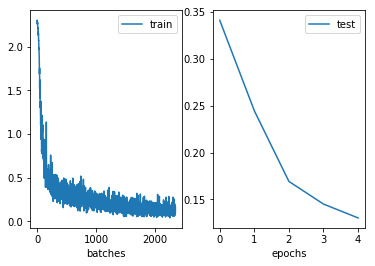

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2)
ax[0].plot(train_loss_history, label="train")
ax[0].set_xlabel("batches")
ax[1].plot(test_loss_history, label="test")
ax[1].set_xlabel("epochs")
ax[0].legend()
ax[1].legend();

## Testing Federation

In [11]:
import federated

def make_model():
    return MLPNet()

manager = federated.FederatedManager(
    [train_dloader],
    make_model,
    nn.CrossEntropyLoss(),  # this needs to be an instance of the class, i.e. an object, i.e. you needed `()`
    Xtest,
    ytest,
)

In [12]:
# compare like with like
for w in manager.workers:
    w.lr = learning_rate

In [13]:
for i in range(num_epochs):
    manager.round()
    print("-->", i, manager.manager_loss_history[-1])

0 2.3076844215393066
100 0.8370888829231262
200 0.4121972620487213
300 0.500619649887085
400 0.2845262587070465
--> 0 0.30804163217544556
0 0.24999183416366577
100 0.25267183780670166
200 0.3568066954612732
300 0.11582835018634796
400 0.22745180130004883
--> 1 0.2461712658405304
0 0.371670663356781
100 0.1418774425983429
200 0.22430670261383057
300 0.16305169463157654
400 0.17781521379947662
--> 2 0.21221373975276947
0 0.16905507445335388
100 0.13505819439888
200 0.12080030888319016
300 0.13447339832782745
400 0.17022590339183807
--> 3 0.14569613337516785
0 0.20676857233047485
100 0.19279523193836212
200 0.28069746494293213
300 0.03295467793941498
400 0.19760127365589142
--> 4 0.12683068215847015


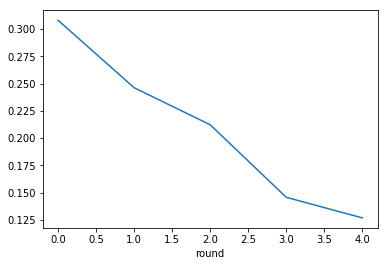

In [14]:
fig, ax = plt.subplots()
# loss of global model on test set gets recorded twice per round
# [1::2] skips the record that takes place before that round's training has happened
ax.plot(manager.manager_loss_history[1::2])
ax.set_xlabel("round");

# Next

 - $>1$ dataloader to federated
 - visualize evolution of manager.workers[0, 1, 2, etc.].loss_history (this should be comparable to the training loss on the non-federated model)
 - stack deck in dataloaders